In [10]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [11]:
root_dir = 'grid_data'

with open(f'{root_dir}/images.txt', 'w') as f:
    for img_file in os.listdir(f'{root_dir}/clothes'):
        f.writelines(f'{img_file.rsplit(".")[0]}\n')
f.close()
    

In [12]:
with open(f'{root_dir}/images.txt', 'r') as f:
    img_list = [line.strip() for line in f.readlines()]

print(img_list)

['mens-clothing-casual-shirts_4BE22D042-A11', 'mens-clothing-basic-t-shirts_YT142D01D-K11', 'mens-athletic-jackets_OP522S00U-K11', '00015_0', '00033_0', 'mens-clothing-casual-shirts_3SE22D1AA-K11', 'mens-clothing-casual-shirts_CAR22D001-K11', 'mens-clothing-casual-shirts_ALK22D000-Q12']


## Landmarks and their codes

| Label | Code |
| --- | --- |
| Left shoulder | 10 |
| Right shoulder | 15 |
| Neck line | 13 |
| Left elbow | 25 |
| Right elbow | 32 |
| Lower chest | 29 |
| Left hand | 49 |
| Right hand | 56 |
| Middle waist | 53 |

In [13]:
def get_max_contour(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) != 0:
        max_c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(max_c)

        return max_c, (x, y, w, h)

In [14]:
def resize_thresh(img, size=(256, 256)):
    img = cv2.resize(img, size)
    return img

In [15]:
def make_grid(image, nrows=4, ncols=4):
    result = np.ones_like(image) * 255

    im_width, im_height, _ = image.shape
    row_width = int(im_width / ncols)
    row_height = int(im_height / nrows)
    
    cell_no = 0
    landmarks = {}
    for i in range(0, nrows):
        for j in range(0, ncols):
            box = (j * row_width, i * row_height, j * row_width +
                   row_width, i * row_height + row_height)
            cell_no += 1
            # if i==j or i == 0 or j == 0 or i == nrows-1 or j == ncols-1:
            if cell_no == 10 or cell_no == 13 or cell_no == 15 \
            or cell_no == 25 or cell_no == 29 or cell_no == 32 \
            or cell_no == 49 or cell_no == 53 or cell_no == 56:
                points = (box[0]+row_width//2, box[1]+row_height//2)
                landmarks[cell_no] = tuple(points)
                
                result[box[1]:box[3], box[0]:box[2]] = image[box[1]:box[3], box[0]:box[2]]
                cv2.rectangle(result, (box[0], box[1]), (box[2], box[3]), (0, 0, 0), 1)
                cv2.putText(result, f'{cell_no}', (box[0]+10, box[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
                cv2.circle(result, points, 1, (255, 0, 0), 2)
    
    return result, landmarks

# plt.imshow(make_grid(image=clothes_box, nrows=8, ncols=8)[0])

In [16]:
def split_image(im, rows, cols, verbose=False, output_dir=None):
    name = "grid"
    im_width, im_height = im.size
    row_width = int(im_width / cols)
    row_height = int(im_height / rows)

    n = 0
    for i in range(0, rows):
        for j in range(0, cols):
            box = (j * row_width, i * row_height, j * row_width +
                   row_width, i * row_height + row_height)
            outp = im.crop(box)
            outp_path = name + "_" + str(n) + ".png"
            outp_path = os.path.join(output_dir, outp_path)
            if verbose:
                print("Exporting image tile: " + outp_path)
            outp.save(outp_path)
            n += 1

In [17]:
clothes_landmarks = {}

for img in img_list:
    clothes = cv2.imread(f'{root_dir}/clothes/{img}.jpg')
    clothes_mask = cv2.imread(f'{root_dir}/clothes_mask/{img}.png', 0)
    
    contour, (x, y, w, h) = get_max_contour(mask=clothes_mask)
    
    clothes_box = clothes[y:y+h,x:x+w]
    clothes_mask_box = clothes_mask[y:y+h,x:x+w]
    
    clothes_box = resize_thresh(clothes_box)
    clothes_mask_box = resize_thresh(clothes_mask_box)
    
    clothes_box_grid, landmarks = make_grid(image=clothes_box, nrows=8, ncols=8)
    clothes_landmarks[img] = landmarks
    
    split_image(im=Image.fromarray(clothes_box), rows=8, cols=8, verbose=False, output_dir='grid_data/grids')
    
    
    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 3, 1)
    # plt.imshow(clothes_box, cmap='gray')
    # plt.subplot(1, 3, 2)
    # plt.imshow(clothes_mask_box, cmap='gray')
    # plt.subplot(1, 3, 3)
    # plt.imshow(clothes_box_grid, cmap='gray')
    # plt.show()

print(clothes_landmarks)

{'mens-clothing-casual-shirts_4BE22D042-A11': {10: (48, 48), 13: (144, 48), 15: (208, 48), 25: (16, 112), 29: (144, 112), 32: (240, 112), 49: (16, 208), 53: (144, 208), 56: (240, 208)}, 'mens-clothing-basic-t-shirts_YT142D01D-K11': {10: (48, 48), 13: (144, 48), 15: (208, 48), 25: (16, 112), 29: (144, 112), 32: (240, 112), 49: (16, 208), 53: (144, 208), 56: (240, 208)}, 'mens-athletic-jackets_OP522S00U-K11': {10: (48, 48), 13: (144, 48), 15: (208, 48), 25: (16, 112), 29: (144, 112), 32: (240, 112), 49: (16, 208), 53: (144, 208), 56: (240, 208)}, '00015_0': {10: (48, 48), 13: (144, 48), 15: (208, 48), 25: (16, 112), 29: (144, 112), 32: (240, 112), 49: (16, 208), 53: (144, 208), 56: (240, 208)}, '00033_0': {10: (48, 48), 13: (144, 48), 15: (208, 48), 25: (16, 112), 29: (144, 112), 32: (240, 112), 49: (16, 208), 53: (144, 208), 56: (240, 208)}, 'mens-clothing-casual-shirts_3SE22D1AA-K11': {10: (48, 48), 13: (144, 48), 15: (208, 48), 25: (16, 112), 29: (144, 112), 32: (240, 112), 49: (16, 2

In [18]:
import json

# Serializing json
json_object = json.dumps(clothes_landmarks)
 
# Writing to sample.json
with open("./grid_data/jsons/clothes_landmarks.json", "w") as outfile:
    outfile.write(json_object)
    outfile.close()

print('Write to json file successfully!')

Write to json file successfully!


### Read model image

(556, 405, 3)
(256, 256, 3)
0.6320987654320988 0.460431654676259


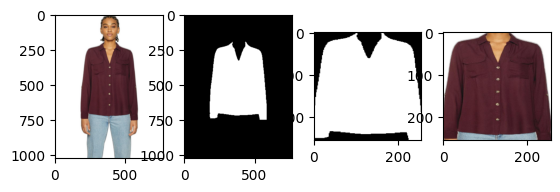

In [19]:
model = cv2.imread(f'{root_dir}/model/00100_0.jpg')
model = cv2.cvtColor(model, cv2.COLOR_BGR2RGB)
model_mask = cv2.imread(f'{root_dir}/model/00100_0.png', 0)

model_mask_contour, (m_x, m_y, m_w, m_h) = get_max_contour(mask=model_mask)
model_mask_box = model_mask[m_y:m_y+m_h,m_x:m_x+m_w]
model_mask_box_r = resize_thresh(model_mask_box)
model_box = model[m_y:m_y+m_h,m_x:m_x+m_w]
box_h, box_w, _ = model_box.shape
model_box_r = resize_thresh(model_box)
boxr_h, boxr_w, _ = model_box_r.shape

width_r = boxr_w / box_w
height_r = boxr_h / box_h

print(model_box.shape)
print(model_box_r.shape)
print(width_r, height_r)

plt.subplot(1, 4, 1)
plt.imshow(model)
plt.subplot(1, 4, 2)
plt.imshow(model_mask, cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(model_mask_box_r, cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(model_box_r, cmap='gray')
plt.show()

### Read  body keypoints

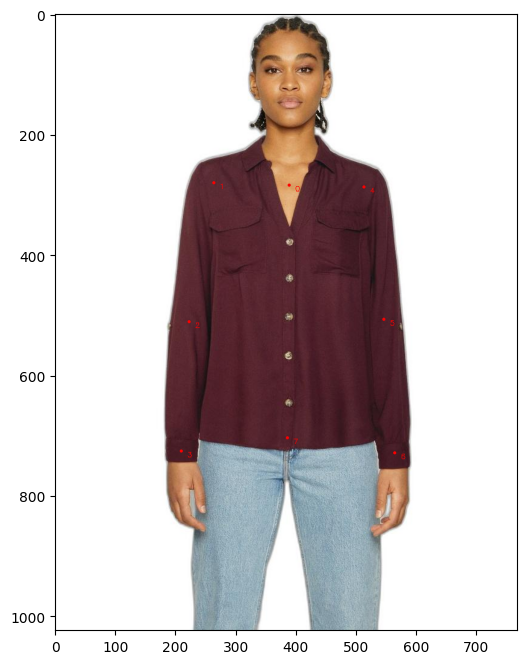

In [20]:
with open("./grid_data/model/00100_0_keypoints.json", "r") as read_file:
    pose_label = json.load(read_file)
    model_pose_ = pose_label['people'][0]['pose_keypoints_2d']
    model_pose_ = np.array(model_pose_).reshape(-1, 3)[:, :2].astype(np.int32)
    read_file.close()

model_pose = []
for ind, pts in enumerate(model_pose_):
    if ind in [1,2,3,4,5,6,7,8,]:
        model_pose.append(pts)
model_pose = np.array(model_pose)

pose_rendered = model.copy()
for ind, pts in enumerate(model_pose):
    cv2.circle(pose_rendered, tuple(pts), 1, (255, 0, 0), 2)
    cv2.putText(pose_rendered, f'{ind}', (pts[0]+10, pts[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

plt.figure(figsize=(8, 8))
plt.imshow(pose_rendered)
plt.show()

### Read clothes landmarks

In [21]:
with open("./grid_data/jsons/clothes_landmarks.json", "r") as read_file:
    clothes_labels = json.load(read_file)
    read_file.close()

print(clothes_labels)

{'mens-clothing-casual-shirts_4BE22D042-A11': {'10': [48, 48], '13': [144, 48], '15': [208, 48], '25': [16, 112], '29': [144, 112], '32': [240, 112], '49': [16, 208], '53': [144, 208], '56': [240, 208]}, 'mens-clothing-basic-t-shirts_YT142D01D-K11': {'10': [48, 48], '13': [144, 48], '15': [208, 48], '25': [16, 112], '29': [144, 112], '32': [240, 112], '49': [16, 208], '53': [144, 208], '56': [240, 208]}, 'mens-athletic-jackets_OP522S00U-K11': {'10': [48, 48], '13': [144, 48], '15': [208, 48], '25': [16, 112], '29': [144, 112], '32': [240, 112], '49': [16, 208], '53': [144, 208], '56': [240, 208]}, '00015_0': {'10': [48, 48], '13': [144, 48], '15': [208, 48], '25': [16, 112], '29': [144, 112], '32': [240, 112], '49': [16, 208], '53': [144, 208], '56': [240, 208]}, '00033_0': {'10': [48, 48], '13': [144, 48], '15': [208, 48], '25': [16, 112], '29': [144, 112], '32': [240, 112], '49': [16, 208], '53': [144, 208], '56': [240, 208]}, 'mens-clothing-casual-shirts_3SE22D1AA-K11': {'10': [48, 

In [22]:
from scipy.spatial.distance import cdist

from lib.interfaces import Mesh
from lib.mc.mc import TriangleMeshCreator
from lib.md.deform import ARAPDeformation

from utils import image_utils as im_utils
from utils import object_utils as obj_utils
from utils import render_utils

/home/anis/Python-Image-Morpher/rigid/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
VISUALIZE = True
DEFORM_MESH_PATH = './deformed_mesh.obj'


def augment_handle_points(poses2d):
    target_poses2d = poses2d.copy()
    for i, loc in enumerate(target_poses2d):
        if i > 6:
            target_poses2d[i] = [loc[0] + 50, loc[1] + 100]
    
    return target_poses2d

def augment_handle_points_(from_poses2d, to_poses2d, from_arr, to_arr):
    to_poses2d_ = to_poses2d.copy().astype(float)
    from_poses2d_ = from_poses2d.copy().astype(float)
    black = to_arr.copy()
    ch, cw, _ = from_arr.shape
    black[0:ch, 0:cw] = from_arr
    overlay = cv2.addWeighted(from_arr, 0.5, to_arr, 0.5, 0)
    
    for i in range(to_poses2d_.shape[0]):
        cv2.line(overlay, from_poses2d_[i].astype(np.int32), to_poses2d_[i].astype(np.int32), (255, 0, 0), 2)
        cv2.circle(overlay, from_poses2d_[i].astype(np.int32), 1, (0, 0, 255), 2)
        cv2.circle(overlay, to_poses2d_[i].astype(np.int32), 1, (0, 255, 0), 2)
        cv2.putText(overlay, f'{i}', (from_poses2d_[i][0].astype(np.int32)+10, from_poses2d_[i][1].astype(np.int32)+10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
        if i in [3, 7, 8]:
            to_poses2d_[i] = from_poses2d_[i]
    
    cv2.imshow('overlay', overlay)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return to_poses2d_

def save_obj_format(file_path, vertices, faces, texture_vertices=None):
    """
    Save obj wavefront to file
    :param file_path:
    :param vertices: in range [-1.,1.]
    :param faces:
    :param texture_vertices
    :return:
    """

    f = open(file_path, 'w')

    # number of vertices
    no_v = len(vertices)
    no_f = len(faces)

    f.write('#vertices: %d\n' % no_v)
    f.write('#faces: %d\n' % no_f)

    # vertices
    for i in range(no_v):
        v = vertices[i]
        f.write("v %.4f %.4f %d\n" % (v[0], v[1], 0))

    # vertices texture
    if texture_vertices is not None:
        # the origin of texture vertices are not TOP-LEFT, but BOT-LEFT
        for i in range(no_v):
            v = texture_vertices[i]
            f.write("vt %.4f %.4f\n" % (v[0], v[1]))

    # triangle faces
    for t in faces:
        f.write("f")
        for i in t:
            f.write(" %d/%d" % (i,i))
        f.write("\n")

    f.close()

For image mens-clothing-casual-shirts_4BE22D042-A11



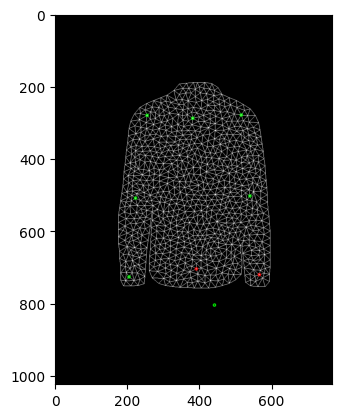

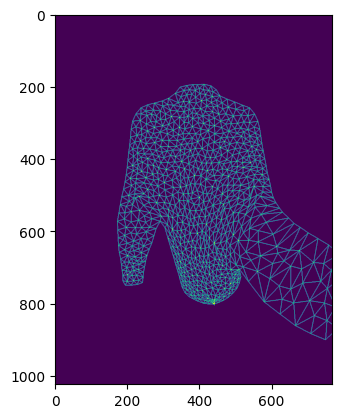

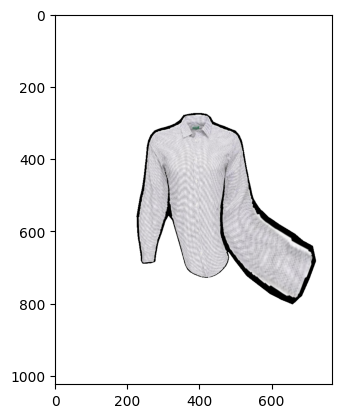

In [26]:
co = 0
for img in clothes_labels:
    if co > 0:
        break
    co += 1
    print(f'For image {img}\n')
    output = model.copy()
    
    clothes = cv2.imread(f'{root_dir}/clothes/{img}.jpg')
    clothes_mask = cv2.imread(f'{root_dir}/clothes_mask/{img}.png', 0)
    
    clothes_lmarks = clothes_labels[img]
    landmarks = [clothes_lmarks[x] for x in clothes_lmarks]
    landmarks = np.reshape(landmarks, (-1, 2))
    landmarks = np.delete(landmarks, 4, axis=0)
    mp_ = [1, 0, 3, 5, 2, 4, 7, 6]
    landmarks = landmarks[mp_]
    
    min_x = min([p[0] for p in model_pose])
    max_x = max([p[0] for p in model_pose])
    min_y = min([p[1] for p in model_pose])
    max_y = max([p[1] for p in model_pose])
    
    scale_height = max_y - min_y
    scale_width = max_x - min_x
    center = (0.5*(min_x + max_x), 0.5*(min_y + max_y))
    
    contour, (x, y, w, h) = get_max_contour(mask=clothes_mask)
    
    clothes_box = clothes[y:y+h,x:x+w]
    clothes_mask_box = clothes_mask[y:y+h,x:x+w]
    
    clothes_box = resize_thresh(clothes_box)
    clothes_mask_box = resize_thresh(clothes_mask_box)
    
    
    cb_h, cb_w, _ = clothes_box.shape
    clothes_box_up = cv2.resize(clothes_box, (model_box.shape[1], model_box.shape[0]))
    clothes_mask_box_up = cv2.resize(clothes_mask_box, (model_box.shape[1], model_box.shape[0]))
    up_h, up_w, _ = clothes_box_up.shape
    up_h_r = up_h / cb_h
    up_w_r = up_w / cb_w
    
    landmarks_up = landmarks.copy()
    for i, lm in enumerate(landmarks):
        landmarks_up[i] = (int(lm[0]*up_w_r+m_x), int(lm[1]*up_h_r)+m_y)
    
    clothes_mask_to_model_size = np.zeros_like(model_mask)*255
    clothes_mask_to_model_size[m_y:m_y+up_h, m_x:m_x+up_w] = clothes_mask_box_up
    clothes_mask_to_model_size[clothes_mask_to_model_size > 127] = 255
    clothes_mask_to_model_size[clothes_mask_to_model_size < 127] = 0
    
    clothes_to_model_size = np.ones_like(model)*255
    clothes_to_model_size[m_y:m_y+up_h, m_x:m_x+up_w] = clothes_box_up
    clothes_to_model_size = cv2.bitwise_and(clothes_to_model_size, clothes_to_model_size, mask=clothes_mask_to_model_size)
    
    model__ = model.copy()
    model_box = model_box.copy()
    model_box_cc = model_box_r.copy()
    model_pose_up = model_pose.copy()
    # for i, loc in enumerate(model_pose):
    #     target_x, target_y = loc
    #     mb_loc = (target_x-m_x, target_y-m_y)
    #     mbc_loc = (int(mb_loc[0]*width_r), int(mb_loc[1]*height_r))
        
    #     # cv2.circle(model__, loc, 1, (0, 128, 50), 2)
    #     # cv2.circle(model_box, mb_loc, 1, (255, 0, 0), 2)
    #     # cv2.circle(model_box_cc, mbc_loc,1, (0, 0, 255), 2)
    #     model_pose_up[i] = mbc_loc
        
    # print(model_pose_up)
    # cv2.imshow('model', model__)
    # cv2.imshow('model_box', model_box)
    # cv2.imshow('model_box_cc', model_box_cc)
    # cv2.imshow('clothes_to_model_size', clothes_to_model_size)
    # cv2.imshow('clothes_mask_to_model_size', clothes_mask_to_model_size)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    tri_mc = TriangleMeshCreator(interval=20, angle_constraint=15, area_constraint=200, dilated_pixel=15)
    mesh = tri_mc.create(clothes_to_model_size, clothes_mask_to_model_size)
    
    poses2d = model_pose.copy()
    
    h, w, _ = model.shape
    vertices = 0.5 * (mesh.vertices + 1) * np.array([w, h]).reshape((1, 2)).astype(np.float32)
    distance = cdist(poses2d, vertices)
    constraint_v_ids = np.argmin(distance, axis=1)
    poses2d = vertices[constraint_v_ids]
    
    # constraint_v_coords = augment_handle_points_(original_keypoints=poses2d, target_keypoints=landmarks_up, from_arr=model, to_arr=clothes_to_model_size)
    constraint_v_coords = augment_handle_points(poses2d)

    constraint_v_ids = np.array([e for i, e in enumerate(constraint_v_ids) if i != 6])
    constraint_v_coords = np.array([e for i, e in enumerate(constraint_v_coords) if i != 6])

    if VISUALIZE:
        vis_image = mesh.get_image()
        vis_image = cv2.cvtColor(vis_image, cv2.COLOR_GRAY2BGR)
        for x, y in poses2d.astype(np.int32):
            cv2.circle(vis_image, (x, y), radius=3, color=(255, 0, 0), thickness=2)

        for x, y in constraint_v_coords.astype(np.int32):
            cv2.circle(vis_image, (x, y), radius=3, color=(0, 255, 0), thickness=2)

        im_utils.imshow(vis_image)

    constraint_v_coords = Mesh.normalize_vertices(constraint_v_coords, size=(w, h))
    
    vts = 0.5 * (mesh.vertices + 1)
    vts[:, 1] = 1. - vts[:, 1]

    arap_deform = ARAPDeformation()
    arap_deform.load_from_mesh(mesh)
    arap_deform.setup()

    deformed_mesh = arap_deform.deform(constraint_v_ids, constraint_v_coords, w=1000.)
    save_obj_format(file_path=DEFORM_MESH_PATH, vertices=deformed_mesh.vertices, faces=deformed_mesh.faces,
                    texture_vertices=vts)
    
    cv2.imwrite(f'./tmp/tmp_clothes.png', clothes_to_model_size)
    
    if VISUALIZE:
        vis_image = deformed_mesh.get_image(size=(w, h))
        im_utils.imshow(vis_image)
    pt_renderer = render_utils.PytorchRenderer(use_gpu=False)
    deformed_image = pt_renderer.render_w_texture(DEFORM_MESH_PATH, f'./tmp/tmp_clothes.png')
    # deformed_image = pt_renderer.render_w_texture(DEFORM_MESH_PATH, f'{root_dir}/model/00100_0.jpg')
    deformed_image = deformed_image[::-1, :, :]
    deformed_image = cv2.cvtColor(deformed_image, cv2.COLOR_BGR2RGB)
    
    # cv2.addWeighted(deformed_image, 0.5, model, 0.5, 0, deformed_image)

    cv2.imwrite('./images/deformed.jpg', cv2.cvtColor(deformed_image, cv2.COLOR_BGR2RGB))
    im_utils.imshow(deformed_image)

In [ ]:
mp = model_pose.copy()
lm = landmarks.copy()
lm = np.delete(lm, 4, axis=0)
mp_ = [1, 0, 3, 5, 2, 4, 7, 6]
lm = lm[mp_]

for i, loc in enumerate(mp):
    target_x, target_y = loc
    offset_x, offset_y = lm[i]
    
    import random
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    cv2.line(output, (target_x, target_y), (offset_x, offset_y), (r, g, b), 3)
    cv2.circle(output, (target_x, target_y), 1, (0, 255, 0), 2)
    cv2.putText(output, str(i), (target_x, target_y), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 2)
    cv2.circle(output, (offset_x, offset_y), 1, (255, 0, 0), 2)
    cv2.putText(output, str(i), (offset_x, offset_y), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(output)

In [ ]:
import cv2
import numpy as np
from scipy.spatial import Delaunay

def apply_delaunay_transform(source_img, target_img, source_points, target_points):
    # Perform Delaunay triangulation on the corresponding points
    tri = Delaunay(target_points)

    # Create an output image with the same size as the target image
    output_img = np.zeros_like(target_img)

    # Iterate over each triangle in the Delaunay triangulation
    for triangle_indices in tri.simplices:
        # Get the corresponding points from both images
        source_triangle = source_points[triangle_indices]
        target_triangle = target_points[triangle_indices]

        # Calculate the affine transformation matrix
        transform = cv2.getAffineTransform(source_triangle, target_triangle)

        # Warp the source triangle to match the target triangle
        warped_triangle = cv2.warpAffine(source_img, transform, (target_img.shape[1], target_img.shape[0]), None,
                                         flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

        # Create a mask for the triangle
        mask = np.zeros_like(target_img)
        cv2.fillConvexPoly(mask, target_triangle.astype(np.int32), (1, 1, 1))

        # Apply the mask to the target image
        output_img = output_img * (1 - mask) + warped_triangle * mask

    return output_img

result_img = apply_delaunay_transform(model, clothes_box, model_pose.astype(np.float32), lm.astype(np.float32))

# Display the result
cv2.imshow('Result', result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
